## Langgraph based Agent-RAG Implementation

In [3]:
from model_md import get_retriever
import json
from langchain_core.messages import HumanMessage, SystemMessage
from get_llm import get_llm

## Get the retriever: Assume we have already run the ingest and populated the vector store
### Check the retriever using some sample queries

In [7]:
retriever = get_retriever().as_retriever(search_kwargs={"k": 8})

In [9]:
query1 = "Explain WebBaseRetriever to load web content"
docs = retriever.invoke(query1)

In [13]:
def print_retrieved_docs(docs):
    for doc in docs:
        print("-" * 100)
        print(doc.page_content)

In [14]:
print_retrieved_docs(docs)

----------------------------------------------------------------------------------------------------
The Webbrowser Tool gives your agent the ability to visit a website and extract information. It is described to the agent as

```
useful for when you need to find something on or summarize a webpage. input should be a comma separated list of "valid URL including protocol","what you want to find on the page or empty string for a summary".
```

It exposes two modes of operation:

- when called by the Agent with only a URL it produces a summary of the website contents
- when called by the Agent with a URL and a description of what to find it will instead use an in-memory Vector Store to find the most relevant snippets and summarise those

## Setup

To use the Webbrowser Tool you need to install the dependencies:

```bash npm
npm install cheerio axios
```
## Usage, standalone

```typescript
import { WebBrowser } from "@langchain/classic/tools/webbrowser";
import { ChatOpenAI, OpenAIEmbeddin

In [15]:
query2 = "Who won the India versus South Africa one day internation cricket match on 3rd dec 2025?"
docs2 = retriever.invoke(query2)

In [16]:
print_retrieved_docs(docs2)

----------------------------------------------------------------------------------------------------
\n\n|\n| \n*   v\n*   t\n*   e\nArgentina squad – 2021 Copa América winners (15th title)\n|\n| --- |\n| \n\n1\xa0Armani\n2\xa0Martínez Quarta\n3\xa0Tagliafico\n4\xa0Montiel\n5\xa0Paredes\n6\xa0Pezzella\n7\xa0De Paul\n8\xa0Acuña\n9\xa0Agüero\n10\xa0Messi\xa0(c)\n11\xa0Di María\n12\xa0Marchesín\n13\xa0Romero\n14\xa0Palacios\n15\xa0González\n16\xa0J. Correa\n17\xa0Domínguez\n18\xa0Rodríguez\n19\xa0Otamendi\n20\xa0Lo Celso\n21\xa0Á. Correa\n22\xa0La. Martínez\n23\xa0E. Martínez\n24\xa0Gómez\n25\xa0Li. Martínez\n26\xa0Molina\n27\xa0Alvarez\n28\xa0Musso\nCoach:\xa0Scaloni\n\n| \n\n|\n| \n*   v\n*   t\n*   e\nArgentina squad – 2022 FIFA World Cup winners (3rd title)\n|\n| --- |\n| \n\n1\xa0Armani\n2\xa0Foyth\n3\xa0Tagliafico\n4\xa0Montiel\n5\xa0Paredes\n6\xa0Pezzella\n7\xa0De Paul\n8\xa0Acuña\n9\xa0Alvarez\n10\xa0Messi\xa0(c)\n11\xa0Di María\n12\xa0Rulli\n13\xa0Romero\n14\xa0Palacios\n15\xa0Co

In [17]:
llm = get_llm()

## ROUTER Implementation using llm guided by the below prompt

In [18]:
# ----------------------------------------------------------- Router Prompt ----------------------------------------------------------
router_instructions = """You are an expert at routing a user question to a vectorstore or web search.

The vectorstore contains documentation for LangChain and LangGraph products.
                                    
Use the vectorstore for questions on these topics. 

For questions where you know the answer, you can directly answer.

For all else where you may not have the accurate answer, such as current events or time dependent information use web-search.

Return JSON with single key, datasource, that is 'websearch' or 'vectorstore' depending on the question.

Enclose your JSON output within the code fence: ```json and ```

Do not provide any other information

"""


In [36]:
query1 = "Explain how to create an agentic application using LangChain"
query2 = "What are the top headlines of today?"
query3 = "What is the weather in Bangalore right now?"
query4 = "What are the types of agent memory?"

In [37]:
# Test router
results1 = llm.invoke([SystemMessage(content=router_instructions)] + [HumanMessage(content=query1)])
print(results1.content)

results2 = llm.invoke([SystemMessage(content=router_instructions)] + [HumanMessage(content=query2)])
print(results2.content)

results3 = llm.invoke([SystemMessage(content=router_instructions)] + [HumanMessage(content=query3)])
print(results3.content)

results4 = llm.invoke([SystemMessage(content=router_instructions)] + [HumanMessage(content=query4)])
print(results4.content)

```json
{
  "datasource": "vectorstore"
}
```
```json
{
  "datasource": "websearch"
}
```

```json
{
  "datasource": "websearch"
}
```

```json
{
  "datasource": "vectorstore"
}
```


## Prompt to implement the Grader for verifying context relevance

In [38]:
### Retrieval Grader 

# Doc grader instructions 
doc_grader_instructions = """You are a grader assessing relevance of a retrieved document to a user question.

If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant."""

# Grader prompt
doc_grader_prompt = """Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}. 

This carefully and objectively assess whether the document contains at least some information that is relevant to the question.

Return JSON with single key, binary_score, that is 'yes' or 'no' score to indicate whether the document contains at least some information that is relevant to the question."""


## Test the Grader for context relevance

### 1. Positive test case

In [41]:
# Test
question = query1
print("Question: ", question)

# Use the vector database to retrieve the top k chunks for the given question
docs = retriever.invoke(question)

txt = ""
for d in docs:
    txt += d.page_content  # 

print(txt)

doc_grader_prompt_formatted = doc_grader_prompt.format(document=txt, question=question)
result = llm.invoke([SystemMessage(content=doc_grader_instructions)] + [HumanMessage(content=doc_grader_prompt_formatted)])

print("Result: ", result.content)

Question:  Explain how to create an agentic application using LangChain
```python

```

```javascript

```

LangChain is the easiest way to start building agents and applications powered by LLMs. With under 10 lines of code, you can connect to OpenAI, Anthropic, Google, and [more](/oss/integrations/providers/overview). LangChain provides a pre-built agent architecture and model integrations to help you get started quickly and seamlessly incorporate LLMs into your agents and applications.

We recommend you use LangChain if you want to quickly build agents and autonomous applications. Use [LangGraph](/oss/langgraph/overview), our low-level agent orchestration framework and runtime, when you have more advanced needs that require a combination of deterministic and agentic workflows, heavy customization, and carefully controlled latency.

LangChain [agents](/oss/langchain/agents) are built on top of LangGraph in order to provide durable execution, streaming, human-in-the-loop, persistence, 

### 2. Negative Test Case

In [42]:
# Test
question = query2
print(question)

txt = ""
for d in docs:
    txt += d.page_content  # 

print(txt)

doc_grader_prompt_formatted = doc_grader_prompt.format(document=txt, question=question)
result = llm.invoke([SystemMessage(content=doc_grader_instructions)] + [HumanMessage(content=doc_grader_prompt_formatted)])

print("Result: ", result.content)

What are the top headlines of today?
```python

```

```javascript

```

LangChain is the easiest way to start building agents and applications powered by LLMs. With under 10 lines of code, you can connect to OpenAI, Anthropic, Google, and [more](/oss/integrations/providers/overview). LangChain provides a pre-built agent architecture and model integrations to help you get started quickly and seamlessly incorporate LLMs into your agents and applications.

We recommend you use LangChain if you want to quickly build agents and autonomous applications. Use [LangGraph](/oss/langgraph/overview), our low-level agent orchestration framework and runtime, when you have more advanced needs that require a combination of deterministic and agentic workflows, heavy customization, and carefully controlled latency.

LangChain [agents](/oss/langchain/agents) are built on top of LangGraph in order to provide durable execution, streaming, human-in-the-loop, persistence, and more. You do not need to know L

## Prompt for Answer Generator

In [47]:
### Generate

# Prompt
rag_prompt = """You are an assistant for question-answering tasks. 

Here is the context to use to answer the question:

{context} 

Think carefully about the above context. 

Now, review the user question:

{question}

Provide an answer to this questions using only the above context. 

Use three sentences maximum and keep the answer concise.

Answer:"""

# Post-processing
def format_docs(docs):
    sources = []
    txt = ""
    for doc in docs:
        txt += "\n\n" + doc.page_content
        sources.append(doc.metadata["source"])

    print(f"Sources = {sources}, num_sources = {len(sources)}, num_docs = {len(docs)}")
    
    return txt


### 1. Positive Test Case

In [49]:

# Test
question = query1
docs = retriever.invoke(question)
docs_txt = format_docs(docs)
rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
print("=" * 100)
print(generation.content)

Sources = ['C:\\home\\ananth\\research\\packages\\docs\\src\\oss\\langchain\\overview.mdx', 'C:\\home\\ananth\\research\\packages\\docs\\src\\oss\\python\\integrations\\document_loaders\\docusaurus.mdx', 'C:\\home\\ananth\\research\\packages\\docs\\src\\oss\\python\\releases\\langchain-v1.mdx', 'C:\\home\\ananth\\research\\packages\\docs\\src\\oss\\javascript\\integrations\\document_loaders\\web_loaders\\recursive_url_loader.mdx', 'C:\\home\\ananth\\research\\packages\\docs\\src\\oss\\javascript\\releases\\langchain-v1.mdx', 'C:\\home\\ananth\\research\\packages\\docs\\src\\oss\\learn.mdx', 'C:\\home\\ananth\\research\\packages\\docs\\src\\oss\\python\\integrations\\document_loaders\\diffbot.mdx', 'C:\\home\\ananth\\research\\packages\\docs\\src\\oss\\langgraph\\overview.mdx'], num_sources = 8, num_docs = 8
LangChain offers a straightforward way to build agents with `create_agent`, which simplifies the process compared to LangGraph's more complex approach. This function utilizes middle

### 2. Negative Test Case

In [50]:
# Test
question = query2
docs = retriever.invoke(question)
docs_txt = format_docs(docs)
rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
print("=" * 100)
print(generation.content)

Sources = ['C:\\home\\ananth\\research\\packages\\docs\\src\\oss\\python\\integrations\\tools\\playwright.mdx', 'C:\\home\\ananth\\research\\packages\\docs\\src\\oss\\python\\integrations\\tools\\playwright.mdx', 'C:\\home\\ananth\\research\\packages\\docs\\src\\oss\\python\\integrations\\tools\\playwright.mdx', 'C:\\home\\ananth\\research\\packages\\docs\\src\\oss\\python\\integrations\\tools\\linkup_search.mdx', 'C:\\home\\ananth\\research\\packages\\docs\\src\\oss\\python\\integrations\\tools\\playwright.mdx', 'C:\\home\\ananth\\research\\packages\\docs\\src\\oss\\python\\integrations\\tools\\playwright.mdx', 'C:\\home\\ananth\\research\\packages\\docs\\src\\oss\\python\\integrations\\tools\\agentql.mdx', 'C:\\home\\ananth\\research\\packages\\docs\\src\\oss\\python\\integrations\\retrievers\\linkup_search.mdx'], num_sources = 8, num_docs = 8
Donald Trump has secured more than the 270 Electoral College votes needed to secure the presidency, according to NBC News. Top stories include

## Grader to test for Groundedness

In [51]:
### Hallucination Grader 

# Hallucination grader instructions 
hallucination_grader_instructions = """

You are a teacher grading a quiz. 

You will be given FACTS and a STUDENT ANSWER. 

Here is the grade criteria to follow:

(1) Ensure the STUDENT ANSWER is grounded in the FACTS. 

(2) Ensure the STUDENT ANSWER does not contain "hallucinated" information outside the scope of the FACTS.

Score:

A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score. 

A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 

Avoid simply stating the correct answer at the outset."""

# Grader prompt
hallucination_grader_prompt = """FACTS: \n\n {documents} \n\n STUDENT ANSWER: {generation}. 

Return JSON with two two keys, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER is grounded in the FACTS. And a key, explanation, that contains an explanation of the score."""


### Test using documents and generation from above 

In [52]:
hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(documents=docs_txt, generation=generation.content)
result = llm.invoke([SystemMessage(content=hallucination_grader_instructions)] + [HumanMessage(content=hallucination_grader_prompt_formatted)])
print(result.content)

```json
{
  "binary_score": "yes",
  "explanation": "The student answer accurately reflects information presented in the provided text. Specifically, it correctly states that Donald Trump secured over 270 electoral votes (as projected by NBC News), mentions China competition as a priority for Trump, and notes his picks for secretary positions – all of which are directly supported by the document. The inclusion of 'There are no new news alerts at this time' is also accurate based on the provided text. There is no hallucinated information."
}
```


## Answer Grader Prompt to test "Answer Relevance"

In [53]:
### Answer Grader 

# Answer grader instructions 
answer_grader_instructions = """You are a teacher grading a quiz. 

You will be given a QUESTION and a STUDENT ANSWER. 

Here is the grade criteria to follow:

(1) The STUDENT ANSWER helps to answer the QUESTION

Score:

A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score. 

The student can receive a score of yes if the answer contains extra information that is not explicitly asked for in the question.

A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 

Avoid simply stating the correct answer at the outset."""

# Grader prompt
answer_grader_prompt = """QUESTION: \n\n {question} \n\n STUDENT ANSWER: {generation}. 

Return JSON with two two keys, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER meets the criteria. And a key, explanation, that contains an explanation of the score."""


### Test the Answer Grader

In [54]:

# Test 
question = "What are the vision models released today as part of Llama 3.2?"
answer = "The Llama 3.2 models released today include two vision models: Llama 3.2 11B Vision Instruct and Llama 3.2 90B Vision Instruct, which are available on Azure AI Model Catalog via managed compute. These models are part of Meta's first foray into multimodal AI and rival closed models like Anthropic's Claude 3 Haiku and OpenAI's GPT-4o mini in visual reasoning. They replace the older text-only Llama 3.1 models."

# Test using question and generation from above 
answer_grader_prompt_formatted = answer_grader_prompt.format(question=question, generation=answer)
result = llm.invoke([SystemMessage(content=answer_grader_instructions)] + [HumanMessage(content=answer_grader_prompt_formatted)])
print(result.content)

Okay, let's break down this student answer and determine its score based on the given question and grading criteria.

**1. Understand the Question:**

The question asks specifically about the vision models released *today* as part of Llama 3.2. It's a direct request for a list or identification of these models.

**2. Analyze the Student Answer:**

The student answer provides:

*   Identification of two specific vision models: "Llama 3.2 11B Vision Instruct" and "Llama 3.2 90B Vision Instruct."
*   Information about their availability on Azure AI Model Catalog via managed compute.
*   Contextual information regarding Meta's entry into multimodal AI, comparisons to other models (Anthropic Claude 3 Haiku, OpenAI GPT-4o mini), and the replacement of older Llama 3.1 models.

**3. Evaluate Against Criteria:**

The question asks for a list of vision models released as part of Llama 3.2. The student answer *does* provide this list (the two model names). While the answer includes additional inf

## Define the web search tool - replace the TAVILY_API_KEY

In [55]:
### Search
from langchain_community.tools.tavily_search import TavilySearchResults
import os

os.environ["TAVILY_API_KEY"] = "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"
web_search_tool = TavilySearchResults(k=3)

C:\Users\ananth\AppData\Local\Temp\ipykernel_89016\2349448989.py:6: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  web_search_tool = TavilySearchResults(k=3)


## Define the state for our RAG Agent app

In [56]:
import operator
from typing_extensions import TypedDict
from typing import List, Annotated

class GraphState(TypedDict):
    """
    Graph state is a dictionary that contains information we want to propagate to, and modify in, each graph node.
    """
    question : str # User question
    generation : str # LLM generation
    web_search : str # Binary decision to run web search
    max_retries : int # Max number of retries for answer generation 
    answers : int # Number of answers generated
    loop_step: Annotated[int, operator.add] 
    documents : List[str] # List of retrieved documents

## Define all necessary functions that constitute nodes and booleans for conditional edges

In [58]:
from langchain_core.documents import Document
from langgraph.graph import END

### Nodes
def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Write retrieved documents to documents key in state
    documents = retriever.invoke(question)
    return {"documents": documents}

def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    loop_step = state.get("loop_step", 0)
    
    # RAG generation
    docs_txt = format_docs(documents)
    rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    # TBD JSON parsing
    return {"generation": generation, "loop_step": loop_step+1}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
    # Score each doc
    filtered_docs = []
    web_search = "No" 
    for d in documents:
        doc_grader_prompt_formatted = doc_grader_prompt.format(document=d.page_content, question=question)
        result = llm.invoke([SystemMessage(content=doc_grader_instructions)] + [HumanMessage(content=doc_grader_prompt_formatted)])
        
        # TBD check code fencing and JSON parsing
        
        grade = json.loads(result.content)['binary_score']
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "web_search": web_search}
    
def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])
    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    return {"documents": documents}

### Edges

def route_question(state):
    """
    Route question to web search or RAG 

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    route_question = llm.invoke([SystemMessage(content=router_instructions)] + [HumanMessage(content=state["question"])])

    # TBD: JSON parsing - check for code fencing
    source = json.loads(route_question.content)['datasource']
    if source == 'websearch':
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source == 'vectorstore':
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---")
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    max_retries = state.get("max_retries", 3) # Default to 3 if not provided

    hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(documents=format_docs(documents), generation=generation.content)
    result = llm.invoke([SystemMessage(content=hallucination_grader_instructions)] + [HumanMessage(content=hallucination_grader_prompt_formatted)])

    # TBD JSON parsing - code fencing
    grade = json.loads(result.content)['binary_score']

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        # Test using question and generation from above 
        answer_grader_prompt_formatted = answer_grader_prompt.format(question=question, generation=generation.content)

        # TBD JSON parsing - code fencing
        result = llm.invoke([SystemMessage(content=answer_grader_instructions)] + [HumanMessage(content=answer_grader_prompt_formatted)])
        grade = json.loads(result.content)['binary_score']
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        elif state["loop_step"] <= max_retries:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
        else:
            print("---DECISION: MAX RETRIES REACHED---")
            return "max retries"  
    elif state["loop_step"] <= max_retries:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"
    else:
        print("---DECISION: MAX RETRIES REACHED---")
        return "max retries"

## Define the graph and edges

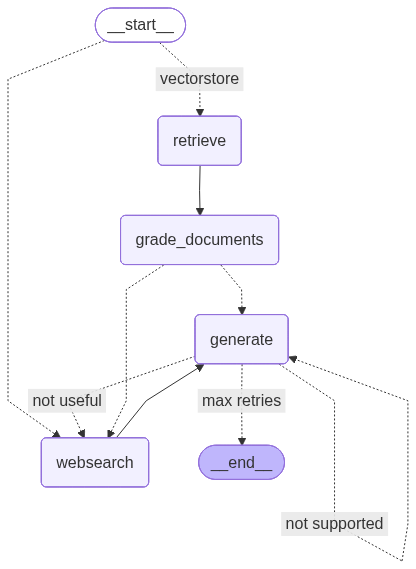

In [59]:
from langgraph.graph import StateGraph
from IPython.display import Image, display

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search) # web search
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("grade_documents", grade_documents) # grade documents
workflow.add_node("generate", generate) # generate

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
        "max retries": END,
    },
)

# Compile
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

## Execute the application - that is the compiled graph

In [60]:
# inputs = {"question": "What is Adobe's revenue for 2023?", "max_retries": 3}
# inputs = {"question": "What are the new products developed Microsoft over 2021 to 2023 and how does it compare with Google during same period?", "max_retries": 3}
inputs = {"question": query2, "max_retries": 3}

for event in graph.stream(inputs, stream_mode="values"):
    print(event)

---ROUTE QUESTION---


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [61]:
response = graph.invoke({"question": query1})

---ROUTE QUESTION---


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
print(response.keys())

In [ ]:
response["generation"].content

In [ ]:
response["documents"]